In [5]:
import os

import numpy as np
import pandas as pd

import librosa
import librosa.display
import soundfile as sf # librosa fails when reading files on Kaggle.

import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [6]:
print(dir(librosa))

['A_weighting', 'LibrosaError', 'ParameterError', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'amplitude_to_db', 'audio', 'autocorrelate', 'beat', 'cache', 'chirp', 'clicks', 'constantq', 'core', 'cqt', 'cqt_frequencies', 'db_to_amplitude', 'db_to_power', 'decompose', 'display', 'dtw', 'effects', 'estimate_tuning', 'feature', 'fft_frequencies', 'fill_off_diagonal', 'filters', 'fmt', 'frames_to_samples', 'frames_to_time', 'get_duration', 'harmonic', 'hybrid_cqt', 'hz_to_mel', 'hz_to_midi', 'hz_to_note', 'hz_to_octs', 'icqt', 'ifgram', 'iirt', 'interp_harmonics', 'istft', 'load', 'magphase', 'mel_frequencies', 'mel_to_hz', 'midi_to_hz', 'midi_to_note', 'note_to_hz', 'note_to_midi', 'octs_to_hz', 'onset', 'output', 'pcen', 'perceptual_weighting', 'phase_vocoder', 'piptrack', 'pitch', 'pitch_tuning', 'power_to_db', 'pseudo_cqt', 're', 'resample', 'salience', 'samples_like', 'samples_to_frames', 'sample

In [35]:
audio_path1 = './input/sjlt1.mp3'
audio_path2 = './input/sjlt2.mp3'

In [37]:
x1, sr1 = librosa.load(audio_path1)

In [39]:
S_full, phase = librosa.magphase(librosa.stft(x1))

In [57]:
print (S_full.shape)

(1025, 7887)


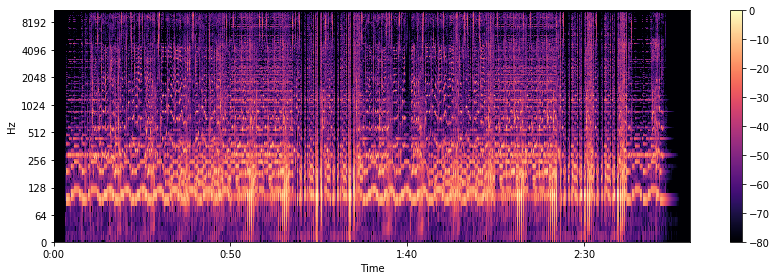

In [48]:
idx = slice(*librosa.time_to_frames([0, 180], sr=sr1))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [49]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr1)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [50]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

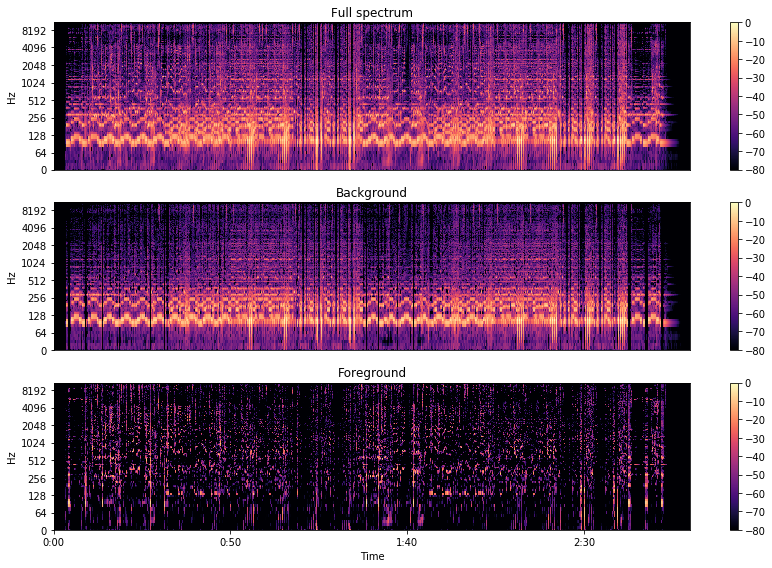

In [51]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [54]:
# librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
#                          y_axis='log', x_axis='time', sr=sr)
print (S_foreground.shape)
print (sr1)
print (x1.shape)

(1025, 7887)
22050
(4037784,)


In [55]:
librosa.display.waveplot(S_foreground, sr=sr)

ParameterError: Input buffer must be contiguous.

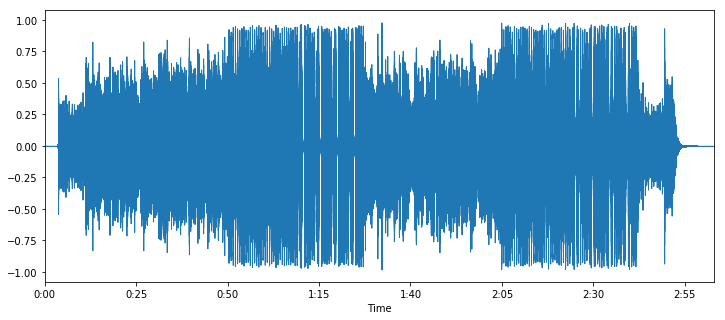

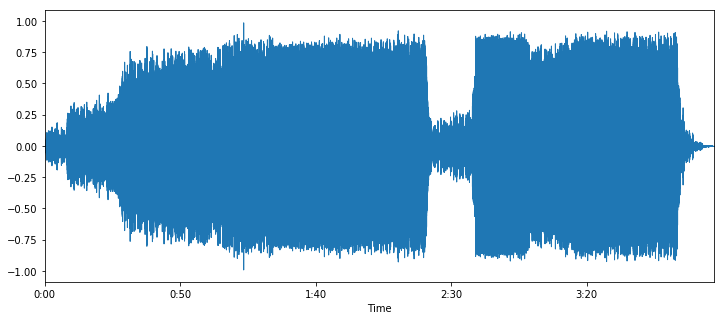

In [38]:
# print (type(x))
# print (type(sr))
# print (sr)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(x1, sr=sr1)
plt.show()

In [29]:
count = 0
for i in range(x.shape[0]):
    if x[i] > 0:
        count = count + 1
print (count)

2595002


In [30]:
print (count/x.shape[0])

0.47608495917597554
